## **BT6270 Computational Neuorscience Assignment-3: Hopfield Networks**

Siddharth Betala (BE19B032)


### Importing the required libraries

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm

### Function to read data as vectors

In [2]:
def data2vec(file_name):
    """
    Function for reading data from files in numpy array format, reshaping it 
    into a column vector, and performing additional pre-processing.
    """
    data = np.loadtxt(file_name+".txt", delimiter=",")
    data_vec = data.reshape(-1,1)
    data_sign = np.sign(data_vec)
    # Make all positions that have 0 as 1
    data_sign[np.where(data_sign==0)] = 1
    clean_data = data_sign
    return clean_data

### Function to generate patches

In [3]:
def generate_patches(data, size=(90,100)):
	"""
	The patch generation function. The patches are generated at random, 
    and the maximum height and width are specified by the min_x, min_y, max_x, 
    and max_y variables.
	"""
	data = data.reshape(size)
	min_x, min_y = 20, 15
	max_x, max_y = 45, 45
	x = random.randint(0, size[0]-max_x-1)
	y = random.randint(0, size[1]-max_y-1)
	dist_x = random.randint(min_x, max_x)
	dist_y = random.randint(min_y, max_y)
	
	patch = np.zeros(size)
	patch[x:x+dist_x, y:y+dist_y] = data[x:x+dist_x, y:y+dist_y]
	
	patch = patch.reshape(-1,1)
	return patch

### All the required visualization functions

In [4]:
def show_img(img, title="", size=(90,100)):
    if img.shape[1] == 1:
        img = img.reshape(size)
        
    plt.figure(figsize=[6,6])
    if title:
        plt.title(title)
        
    plt.imshow(img, cmap='gray')
    plt.show()
    print('\n')

def show_patch(img, patch, title="", size=(90,100)):
    """
    Function to enable side-by-side visualisation of an image and the generated 
    patch of the image.
    """
    if img.shape[1] == 1:
        img = img.reshape(size)
    if patch.shape[1] == 1:
        patch = patch.reshape(size)
        
    plt.figure(figsize=[15,6])
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title+" - Full Image")
    plt.subplot(1, 2, 2)
    plt.imshow(patch, cmap='gray')
    plt.title(title+" - Patch")
    plt.show()
    print('\n')
	
def show_recons(img, patch_before, patch_after, title="", size=(90,100)):
    """
    Function to enable side-by-side visualisation of the entire image, the 
    generated image prior to the epoch reconstruction, and the reconstructed 
    image after the epoch.
    """
    if img.shape[1] == 1:
        img = img.reshape(size)
    if patch_before.shape[1] == 1:
        patch_before = patch_before.reshape(size)
    if patch_after.shape[1] == 1:
        patch_after = patch_after.reshape(size)
        
    plt.figure(figsize=[15,4])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title(title+" - Full Image")
    plt.subplot(1, 3, 2)
    plt.imshow(patch_before, cmap='gray')
    plt.title(title+" -  Before Reconstruction")
    plt.subplot(1, 3, 3)
    plt.imshow(patch_after, cmap='gray')
    plt.title(title+" -  After Reconstruction")
    plt.show()
    print('\n')

def rmse_plotter(rmse, images, title=""):
    """
    Function to plot the RMSE for each of the images: ball, mona and cat
    """
    for i in range(rmse.shape[1]):
        plt.figure()
        plt.plot(rmse[:,i])
        if title:
            plt.title(title + images[i])
            
        plt.grid(True)
        plt.xlabel("Iterations")
        plt.ylabel("RMSE")
        plt.show()
        print('\n')

### Hopfield Networks: Discrete and Continuous
### Function to Damage Weights

In [5]:
def discrete_hopfield(S, W, V_new, max_epochs, dummy=0, every=10, size=(90,100)):
    rmse = []
    ims = []
    
    for i in tqdm(range(max_epochs), desc="Training Discrete Hopfield Network"):
        V = V_new.copy()
        V_new = np.sign(np.matmul(W,V))
        
        if dummy and i%every==0:
            for j in range(V_new.shape[1]):
                show_recons(S[:,j].reshape(-1,1), V[:,j].reshape(-1,1), V_new[:,j].reshape(-1,1), title="Epochs:" + str(i) + "; " + images[j])
                
        rmse_new = []
        ims_new = []
        
        for j in range(V.shape[1]):
            rmse_new.append(mse(S[:,j], V[:,j]))
            ims_new.append([plt.imshow(V[:,j].reshape(size), cmap="gray")])
            
        rmse.append(rmse_new)
        ims.append(ims_new)
        
    V = V_new.copy()
    rmse_new = []
    for j in range(V.shape[1]):
        rmse_new.append(mse(S[:,j], V[:,j]))
        
    rmse.append(rmse_new)
    
    for j in range(V.shape[1]):
        show_recons(S[:,j].reshape(-1,1), V[:,j].reshape(-1,1), V_new[:,j].reshape(-1,1), title="Epochs:" + str(i+1) + "; " + images[j])
        
    return rmse, V, ims

def continuous_hopfield(S, W, V_new, max_epochs, LAMBDA=10, dt=0.01, dummy=0, every=10, size=(90,100)):
	rmse = []
	V_hist = []
	
	U_new = V_new.copy()
	for i in tqdm(range(max_epochs), desc="Training Continuous Hopfield Network"):
		U = U_new.copy()
		V = V_new.copy()
		
		U_new = U + (-U + np.matmul(W, V))*dt
		V_new = np.tanh(LAMBDA*U_new)
		
		if dummy and i%every==0:
			for j in range(V_new.shape[1]):
				show_recons(S[:,j].reshape(-1,1), V[:,j].reshape(-1,1), V_new[:,j].reshape(-1,1), title="Epochs:" + str(i) + "; " + images[j])

		rmse_new = []
		for j in range(V.shape[1]):
			rmse_new.append(mse(S[:,j], V[:,j]))
		rmse.append(rmse_new)
		
		V_hist.append(V)

	V = V_new.copy()
	rmse_new = []
	for j in range(V.shape[1]):
		rmse_new.append(mse(S[:,j], V[:,j]))
	rmse.append(rmse_new)
	V_hist.append(V)
	
	for j in range(V.shape[1]):
		show_recons(S[:,j].reshape(-1,1), V[:,j].reshape(-1,1), V_new[:,j].reshape(-1,1), title="Epochs:" + str(i+1) + "; " + images[j])

	return rmse, V, V_hist

def damage_weights(W, p):
	"""
	Function to damage the weights based on the specified damage fraction.
	"""
	W_damaged = W.copy()
	N = W.shape[0]
	pos = np.random.randint(0, N*N-1, size=(int(N*N*p),1))
	W_damaged = W_damaged.reshape(-1,1)
	W_damaged[pos] = 0
	
	return W_damaged.reshape(N,N)

In [6]:
# Reading the data as vectors
ball = data2vec('ball')
mona = data2vec('mona')
cat = data2vec('cat')

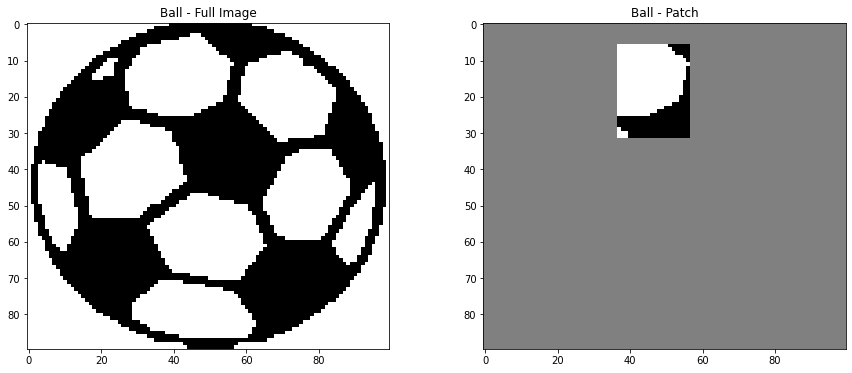

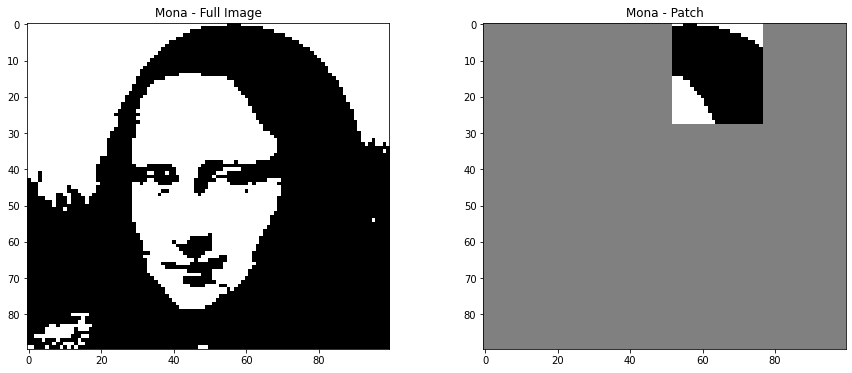

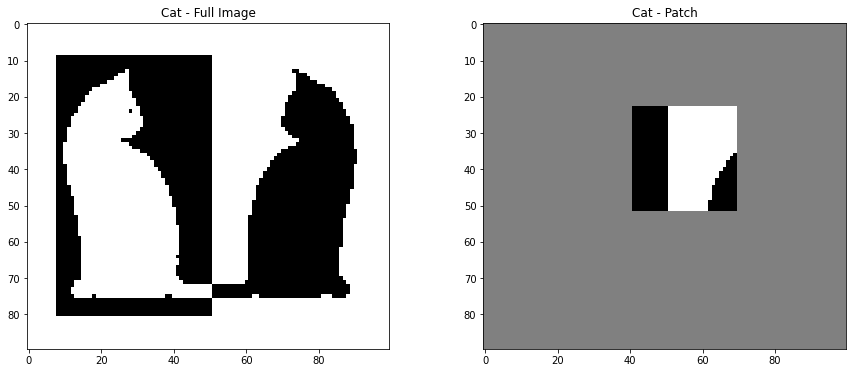

In [7]:
#patches for all 3 images
ball_patch = generate_patches(ball)
mona_patch = generate_patches(mona)
cat_patch = generate_patches(cat)

show_patch(ball, ball_patch, "Ball")
show_patch(mona, mona_patch, "Mona")
show_patch(cat, cat_patch, "Cat")

In [8]:
# Translating concatenation along the column
S = np.c_[ball, mona, cat]
V = np.c_[ball_patch, mona_patch, cat_patch]

V_init = V.copy()
V_new = V.copy()

In [9]:
# Calculate weights
N = S.shape[0]
W = (1/N)*(np.matmul(S, S.T))

In [10]:
images = ["Ball", "Mona", "Cat"]

# To generate plots in using the .py file, use similar framework as given ahead

### RMSE under Discrete Hopfiled Network

Training Discrete Hopfield Network: 100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


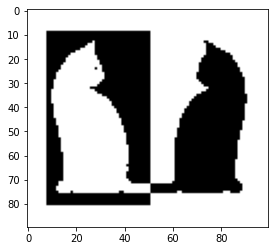

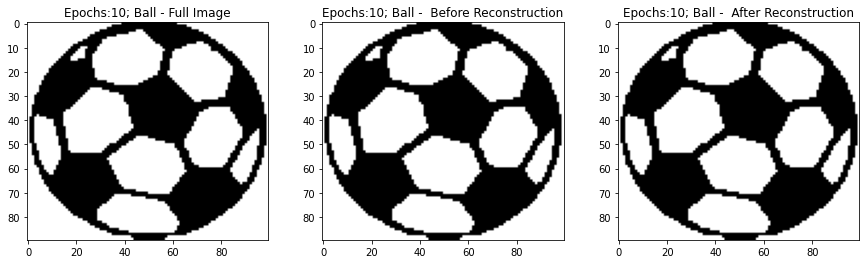

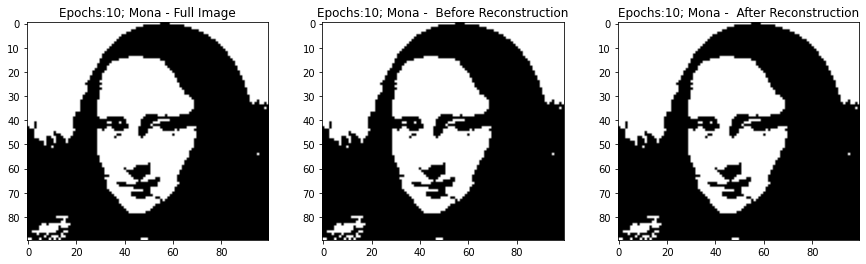

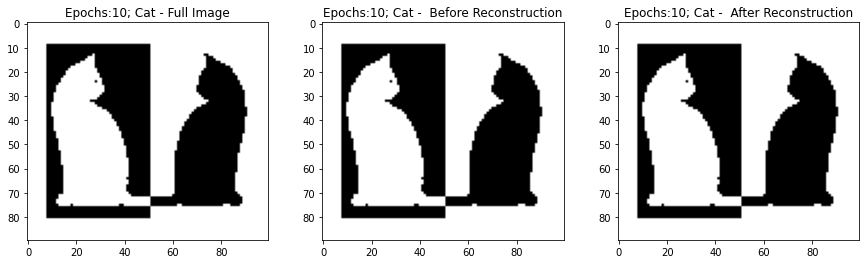

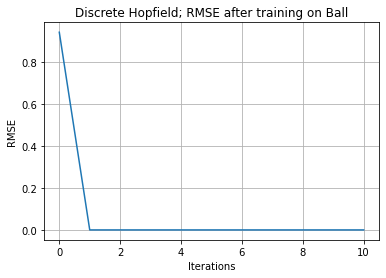

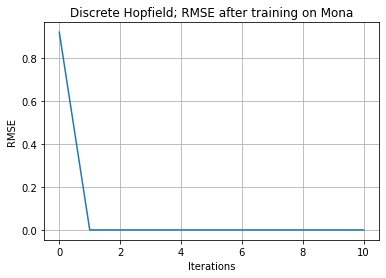

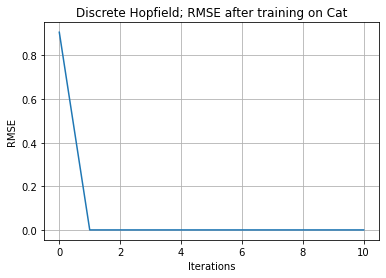

In [11]:
print("="*70)
max_epochs = 10
rmse, V_final, ims = discrete_hopfield(S, W, V_new, max_epochs, dummy=0)

rmse = np.array(rmse)
rmse_plotter(rmse, images, title="Discrete Hopfield; RMSE after training on ")

Rapid convergence to low RMSE is observed for discrete Hopfield

### Continuous Hopfield Networks

#### Under no damage to weights

Training Continuous Hopfield Network:   0%|          | 0/40 [00:00<?, ?it/s]

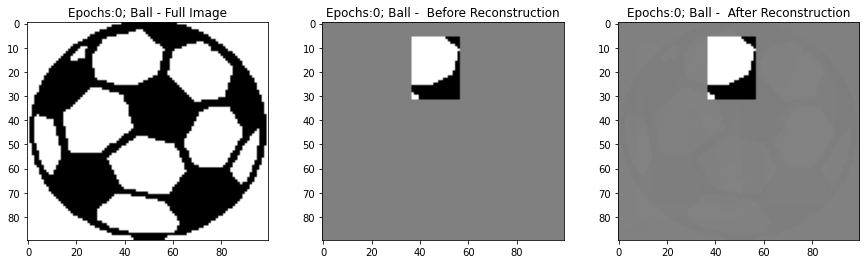

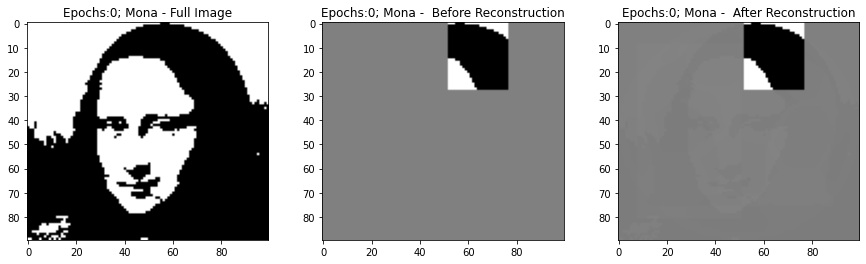

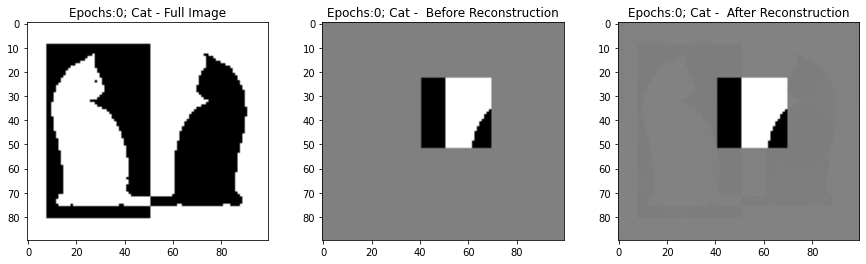

Training Continuous Hopfield Network:   5%|▌         | 2/40 [00:01<00:21,  1.79it/s]

Training Continuous Hopfield Network:  25%|██▌       | 10/40 [00:02<00:03,  7.55it/s]

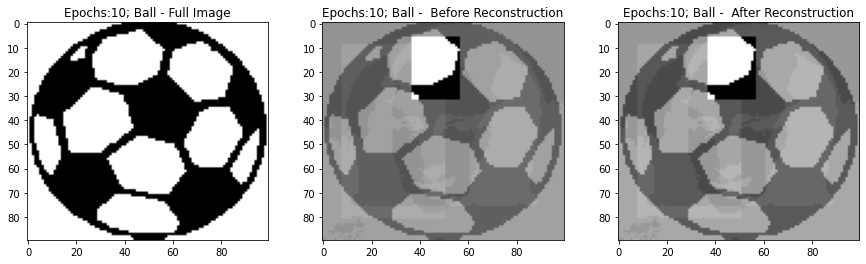

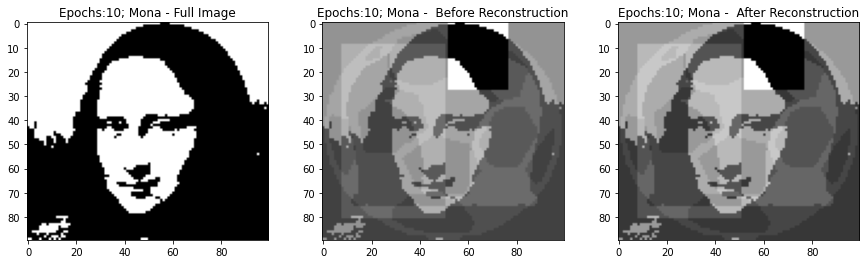

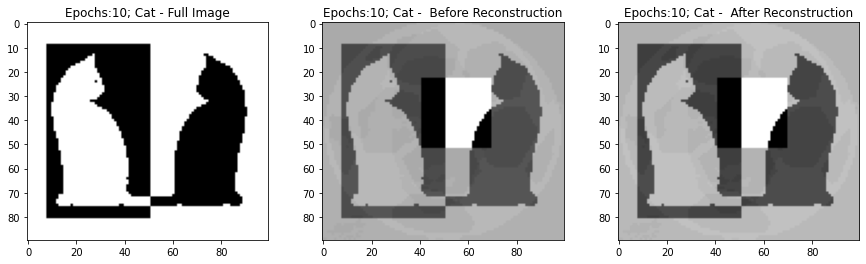

Training Continuous Hopfield Network:  30%|███       | 12/40 [00:03<00:09,  2.87it/s]

Training Continuous Hopfield Network:  50%|█████     | 20/40 [00:04<00:02,  7.37it/s]

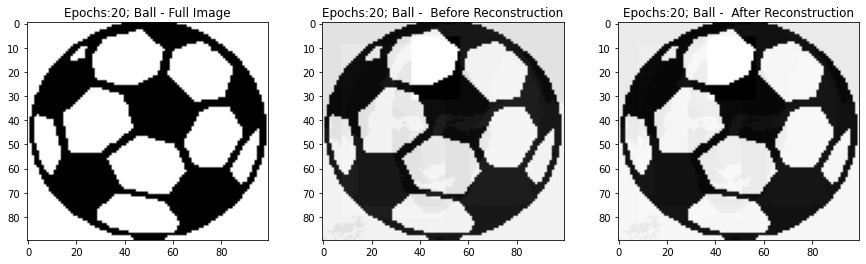

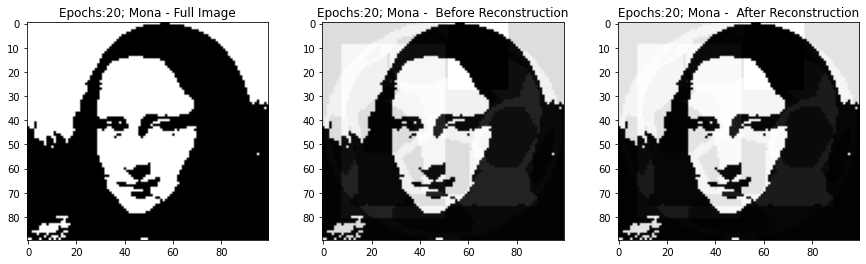

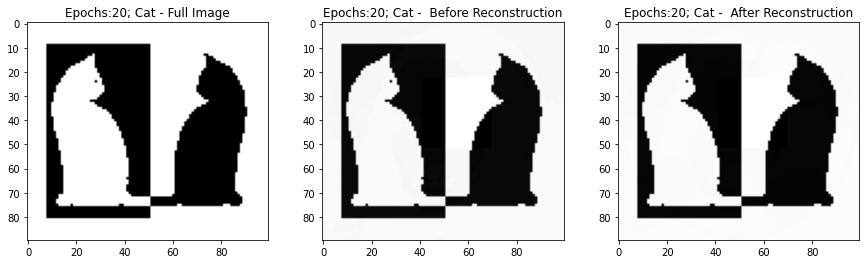

Training Continuous Hopfield Network:  55%|█████▌    | 22/40 [00:05<00:06,  2.75it/s]

Training Continuous Hopfield Network:  75%|███████▌  | 30/40 [00:06<00:01,  7.03it/s]

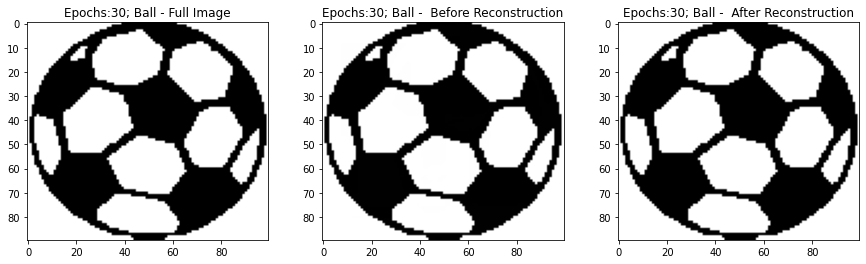

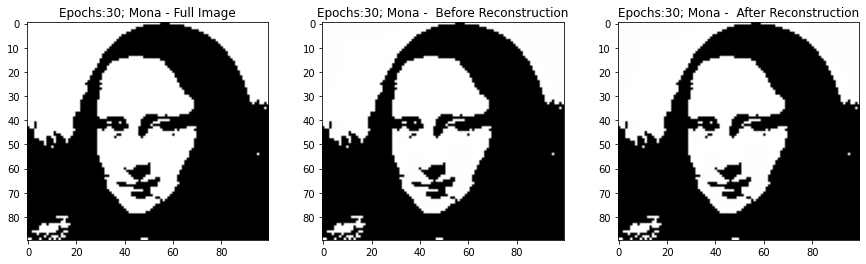

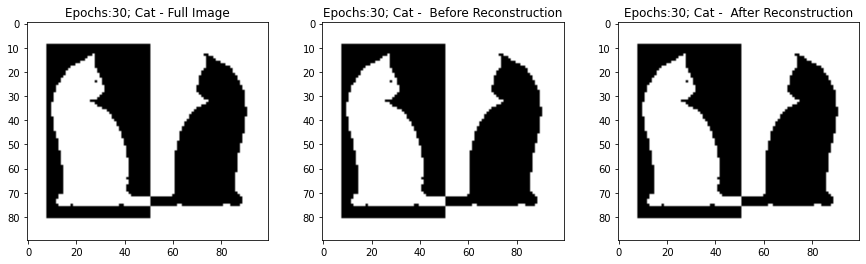

Training Continuous Hopfield Network:  80%|████████  | 32/40 [00:08<00:02,  2.89it/s]

Training Continuous Hopfield Network: 100%|██████████| 40/40 [00:09<00:00,  4.11it/s]


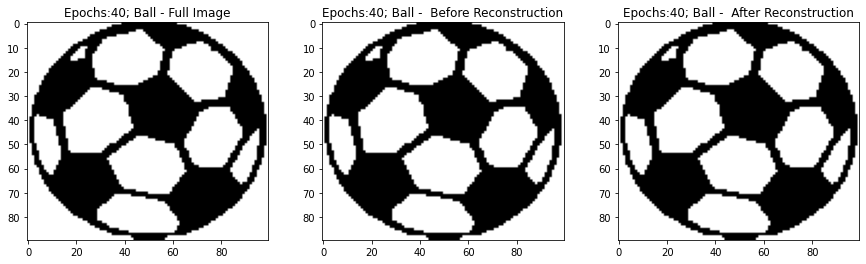

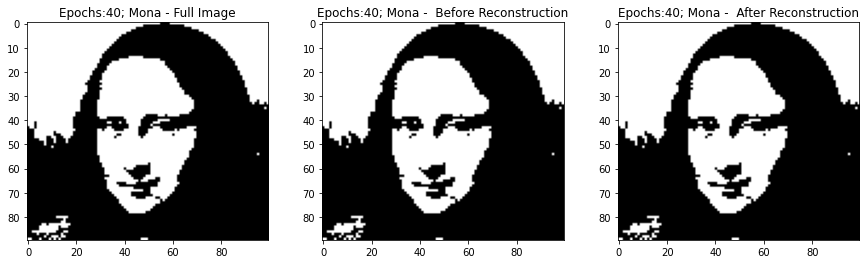

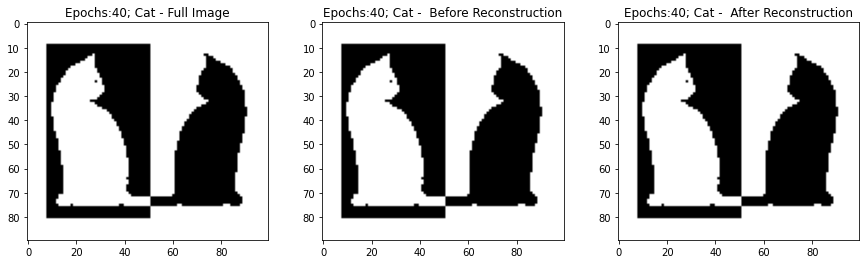

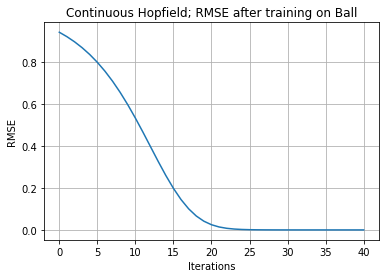

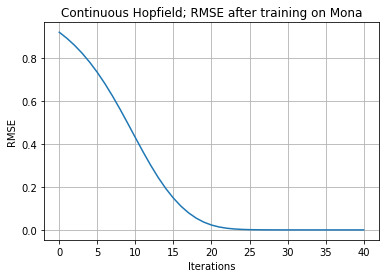

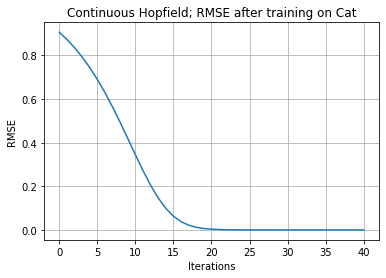

In [12]:
print("="*70)
max_epochs = 40
LAMBDA = 20
dt = 0.01
rmse, V_final, V_hist_0 = continuous_hopfield(S, W, V_new, max_epochs, LAMBDA=LAMBDA, dt=dt, dummy=1, every=10)

rmse = np.array(rmse)
rmse_plotter(rmse, images, title="Continuous Hopfield; RMSE after training on ")

#### Under 25% damage to weights

Training with Damaged Weights
25% Weight Damage


Training Continuous Hopfield Network:   0%|          | 0/40 [00:00<?, ?it/s]

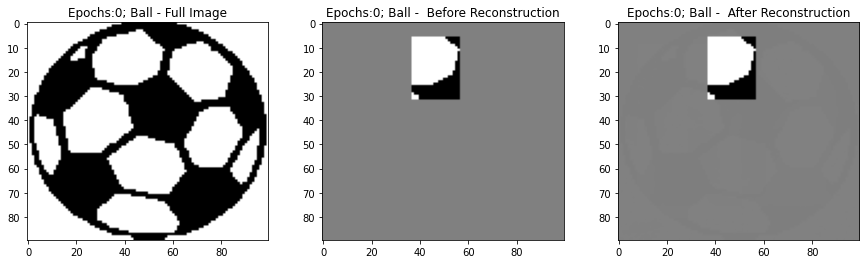

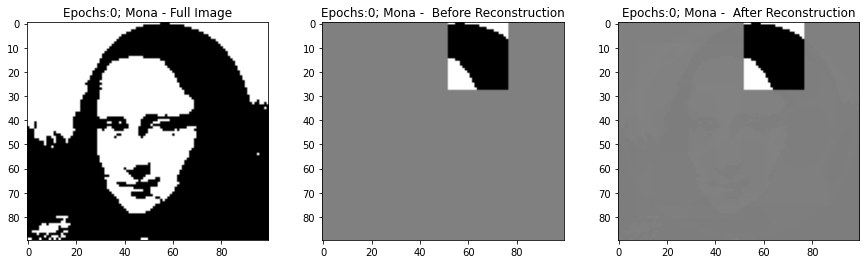

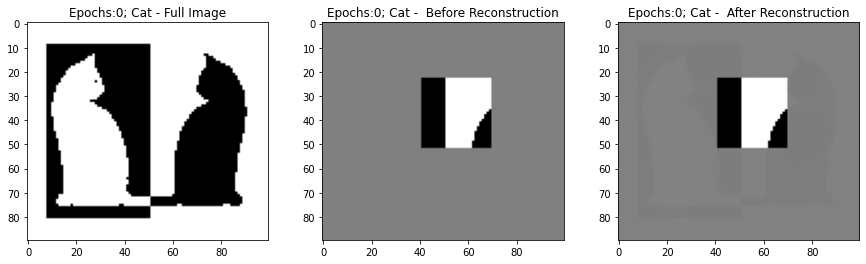

Training Continuous Hopfield Network:   2%|▎         | 1/40 [00:01<00:46,  1.20s/it]

Training Continuous Hopfield Network:  25%|██▌       | 10/40 [00:03<00:07,  4.07it/s]

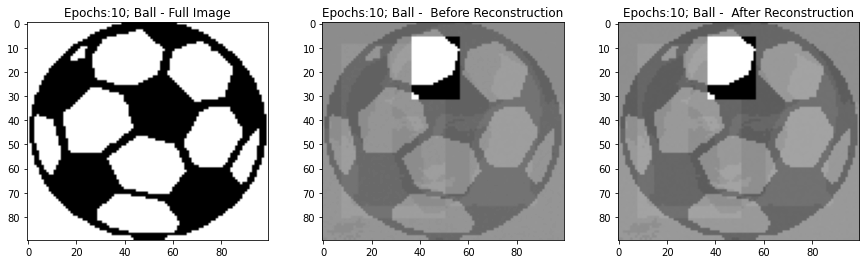

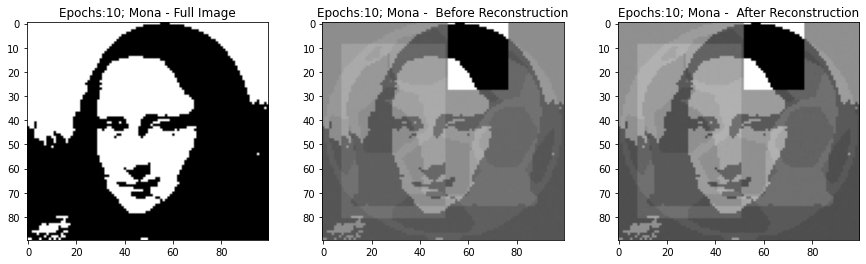

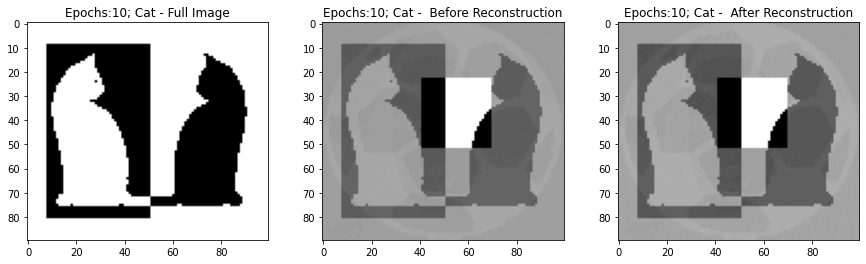

Training Continuous Hopfield Network:  28%|██▊       | 11/40 [00:05<00:26,  1.10it/s]

Training Continuous Hopfield Network:  50%|█████     | 20/40 [00:07<00:03,  5.60it/s]

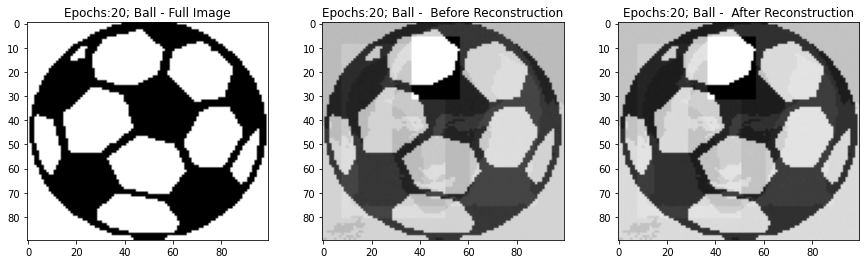

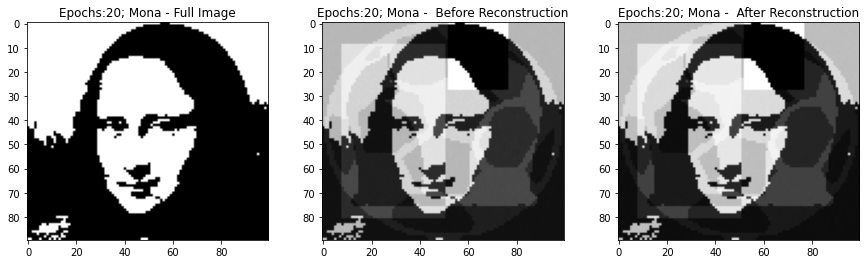

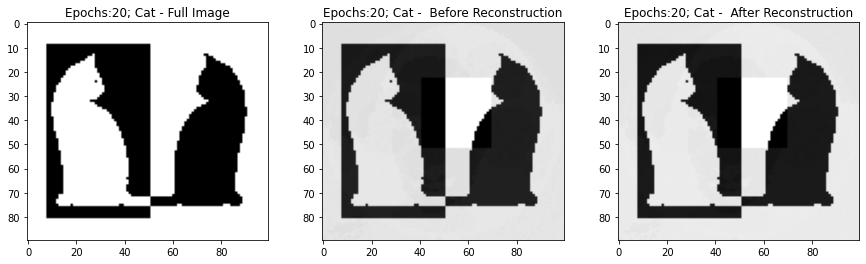

Training Continuous Hopfield Network:  55%|█████▌    | 22/40 [00:08<00:06,  2.58it/s]

Training Continuous Hopfield Network:  75%|███████▌  | 30/40 [00:09<00:01,  7.15it/s]

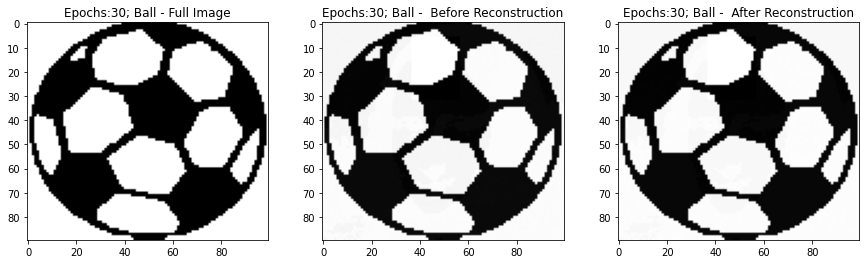

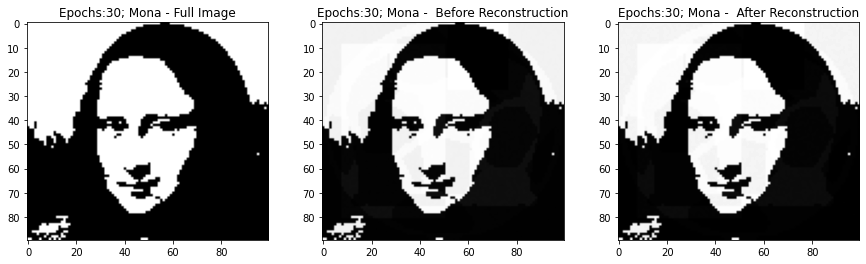

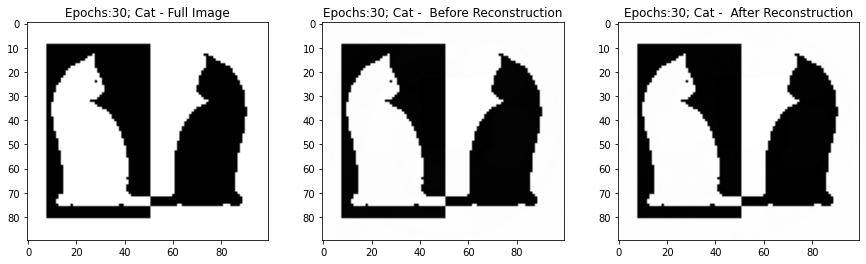

Training Continuous Hopfield Network:  80%|████████  | 32/40 [00:10<00:02,  2.76it/s]

Training Continuous Hopfield Network: 100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


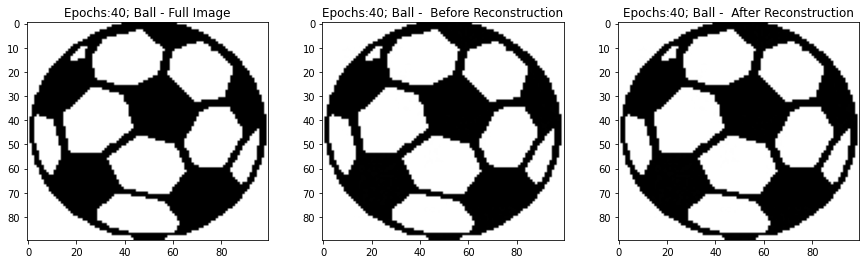

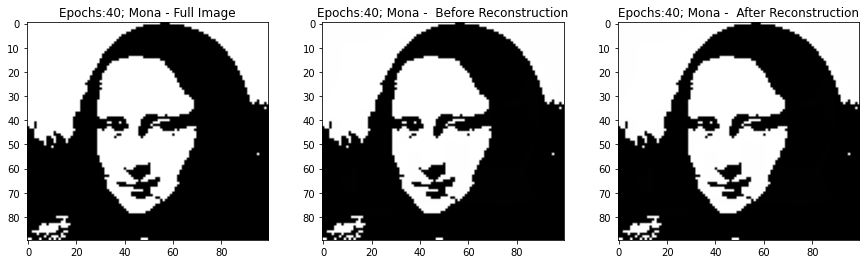

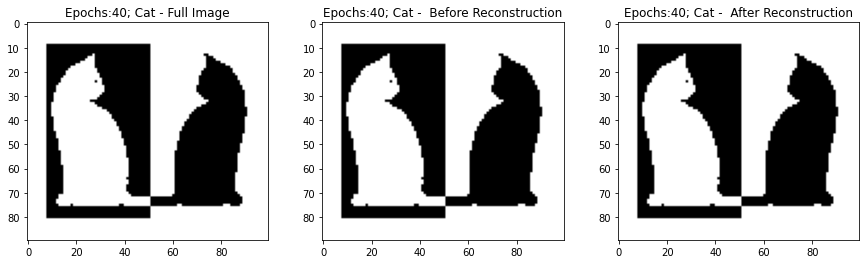

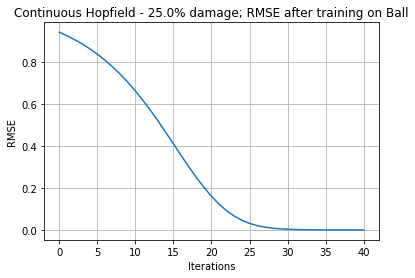

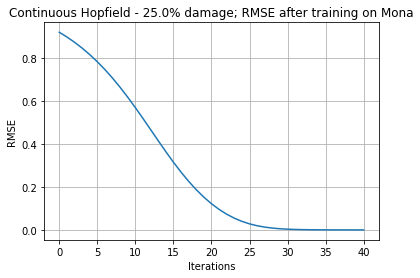

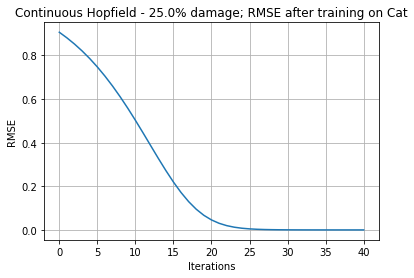

In [13]:
print("="*70)
print("Training with Damaged Weights")
print("="*70)
print("25% Weight Damage")
max_epochs = 40
p = 0.25
rmse, V_final, V_hist_25 = continuous_hopfield(S, damage_weights(W, p), V_new, max_epochs, LAMBDA=LAMBDA, dt=dt, dummy=1, every=10)

rmse = np.array(rmse)
rmse_plotter(rmse, images, title=f"Continuous Hopfield - {p*100}% damage; RMSE after training on ")

#### Under 50% damage to weights

50% Weight Damage


Training Continuous Hopfield Network:   0%|          | 0/50 [00:00<?, ?it/s]

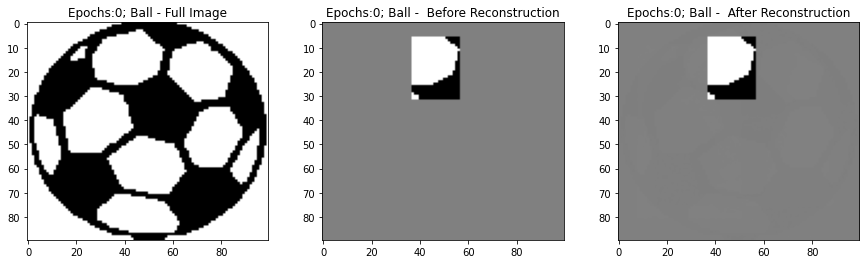

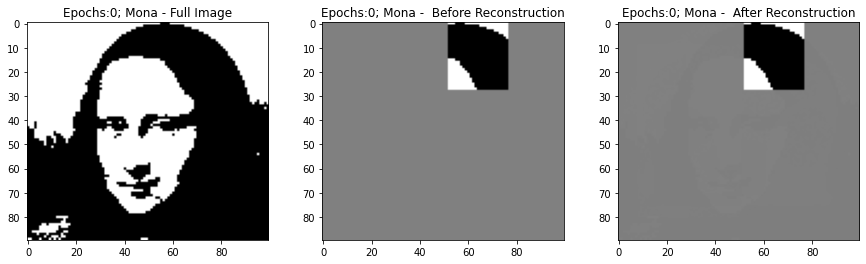

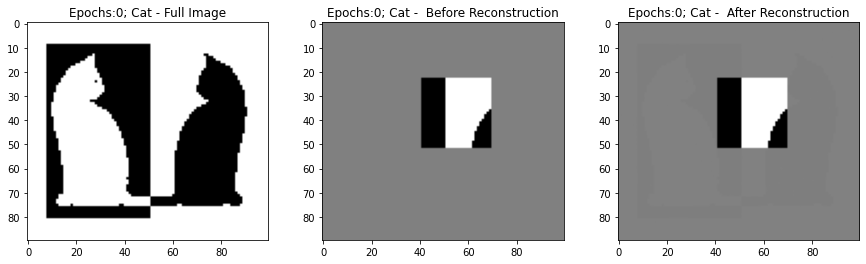

Training Continuous Hopfield Network:   4%|▍         | 2/50 [00:01<00:27,  1.73it/s]

Training Continuous Hopfield Network:  20%|██        | 10/50 [00:02<00:05,  7.39it/s]

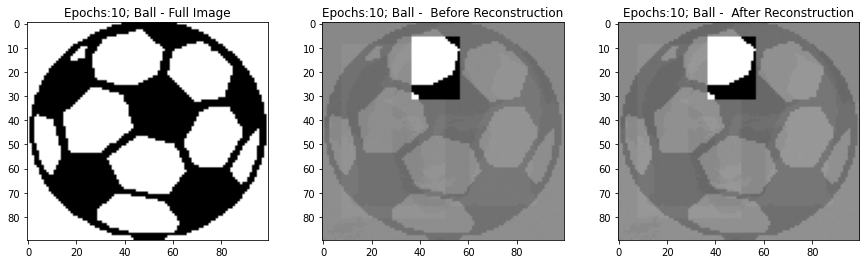

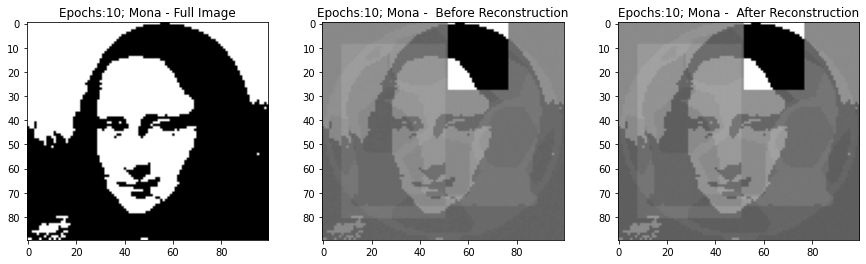

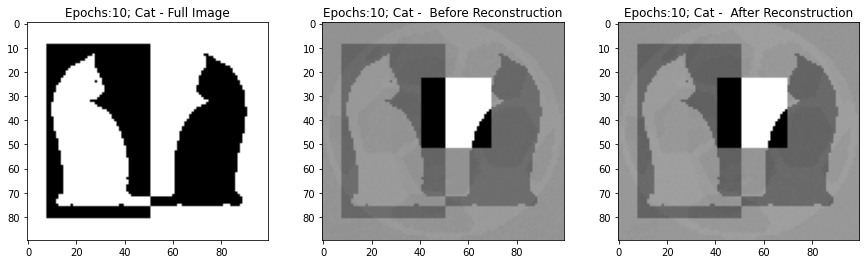

Training Continuous Hopfield Network:  24%|██▍       | 12/50 [00:03<00:13,  2.85it/s]

Training Continuous Hopfield Network:  40%|████      | 20/50 [00:04<00:04,  7.27it/s]

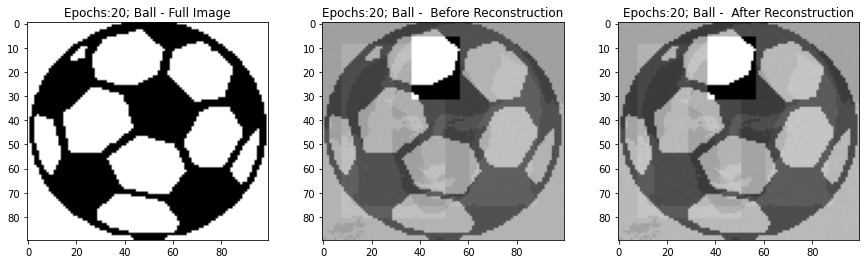

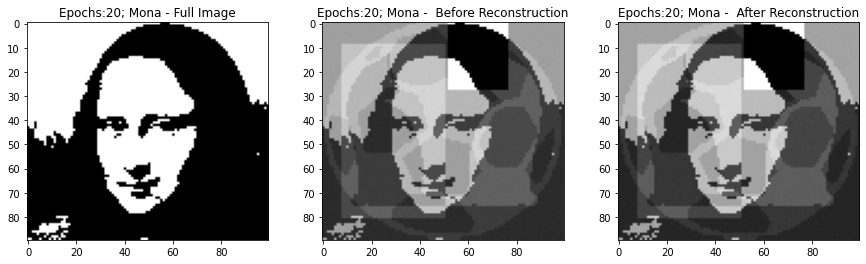

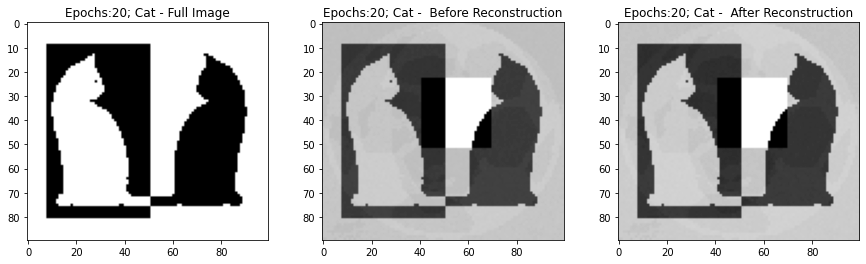

Training Continuous Hopfield Network:  44%|████▍     | 22/50 [00:06<00:10,  2.69it/s]

Training Continuous Hopfield Network:  60%|██████    | 30/50 [00:07<00:02,  7.19it/s]

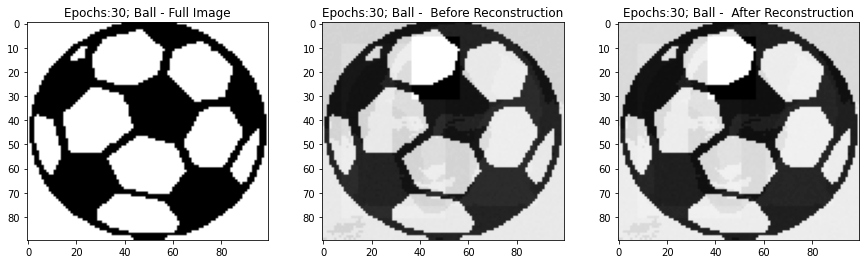

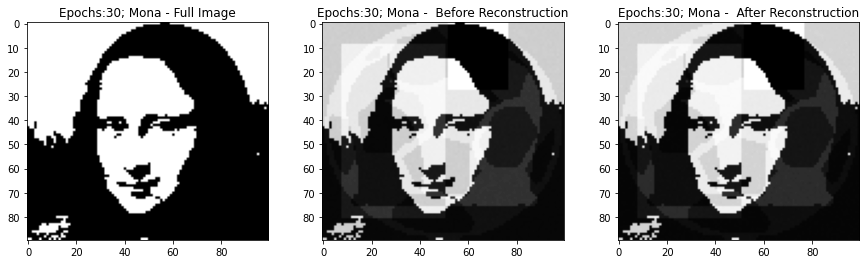

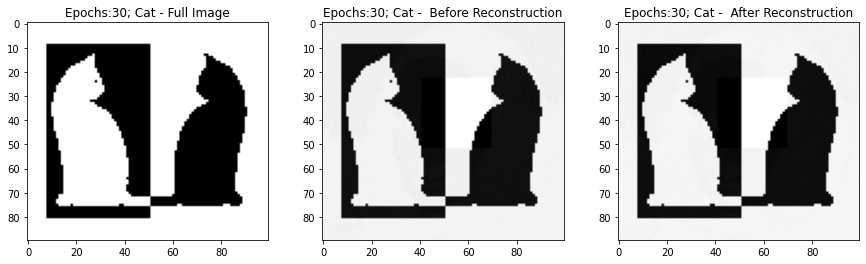

Training Continuous Hopfield Network:  64%|██████▍   | 32/50 [00:08<00:06,  2.79it/s]

Training Continuous Hopfield Network:  80%|████████  | 40/50 [00:09<00:01,  7.23it/s]

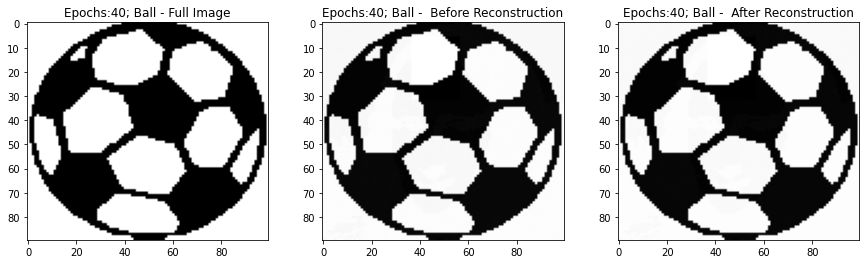

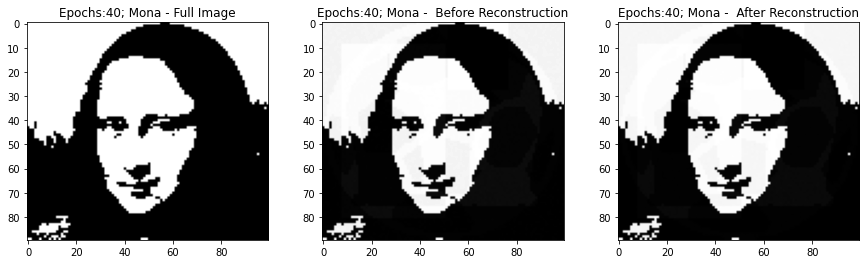

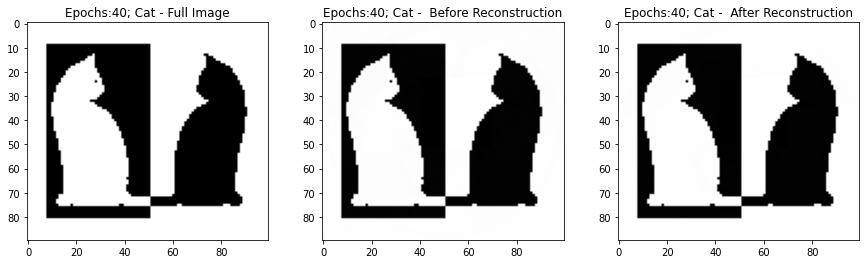

Training Continuous Hopfield Network:  84%|████████▍ | 42/50 [00:10<00:02,  2.72it/s]

Training Continuous Hopfield Network: 100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


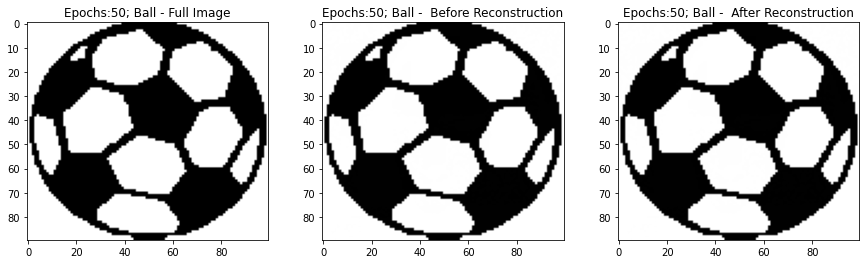

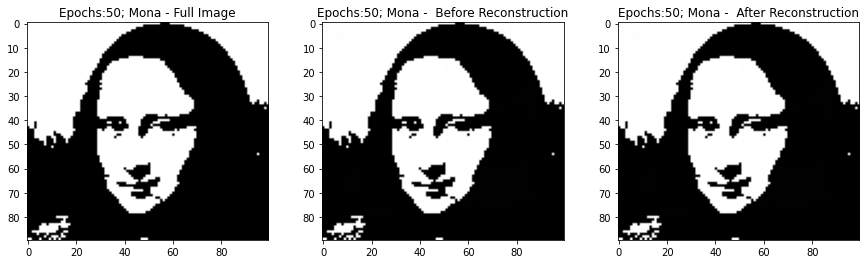

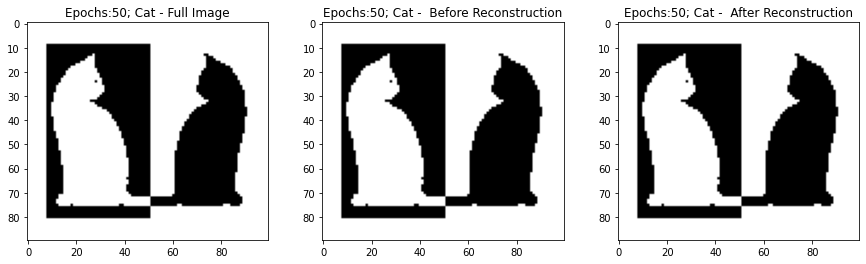

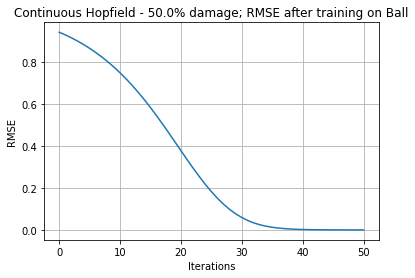

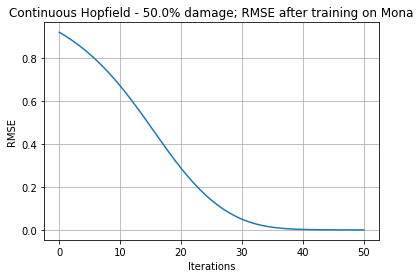

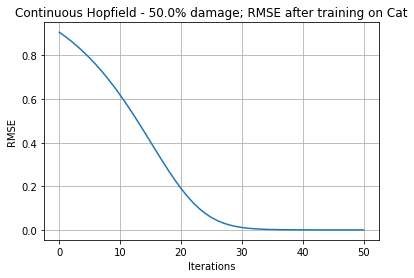

In [14]:
print("="*70)
print("50% Weight Damage")
p = 0.50
max_epochs = 50
rmse, V_final, V_hist_50 = continuous_hopfield(S, damage_weights(W, p), V_new, max_epochs, LAMBDA=LAMBDA, dt=dt, dummy=1, every=10)

rmse = np.array(rmse)
rmse_plotter(rmse, images, title=f"Continuous Hopfield - {p*100}% damage; RMSE after training on ")

#### Under 80% damage to weights

80% Weight Damage


Training Continuous Hopfield Network:   0%|          | 0/70 [00:00<?, ?it/s]

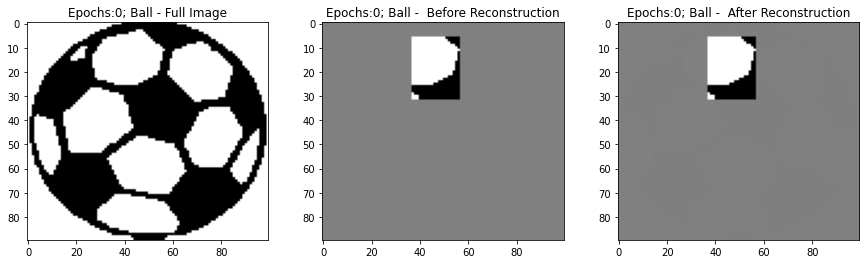

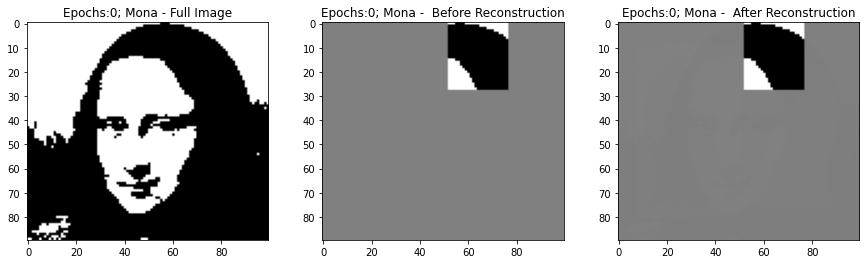

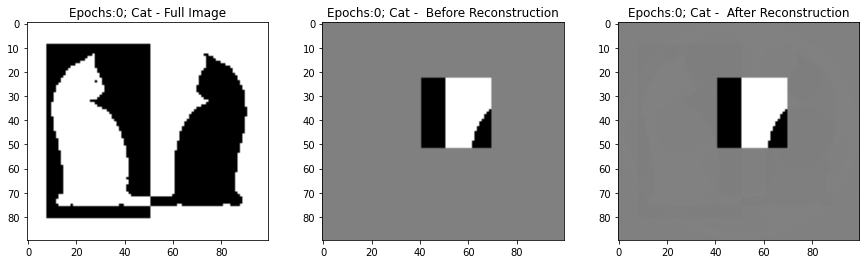

Training Continuous Hopfield Network:   3%|▎         | 2/70 [00:01<00:35,  1.90it/s]

Training Continuous Hopfield Network:  14%|█▍        | 10/70 [00:02<00:07,  7.54it/s]

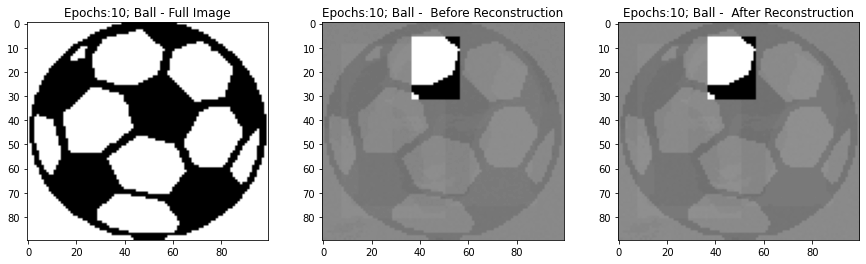

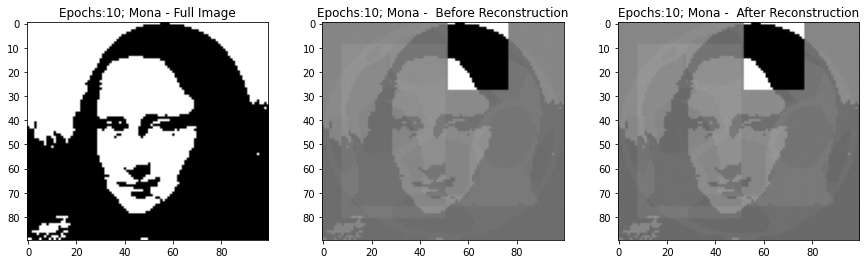

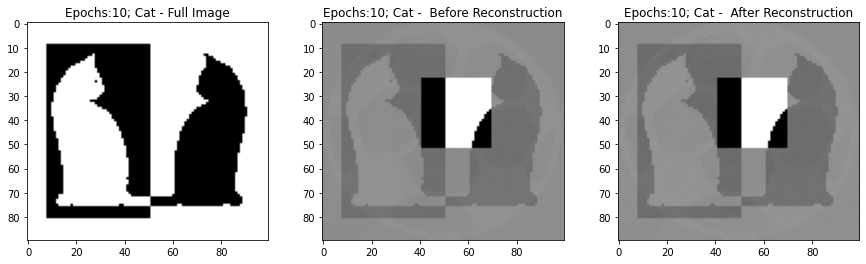

Training Continuous Hopfield Network:  17%|█▋        | 12/70 [00:03<00:21,  2.75it/s]

Training Continuous Hopfield Network:  29%|██▊       | 20/70 [00:04<00:06,  7.36it/s]

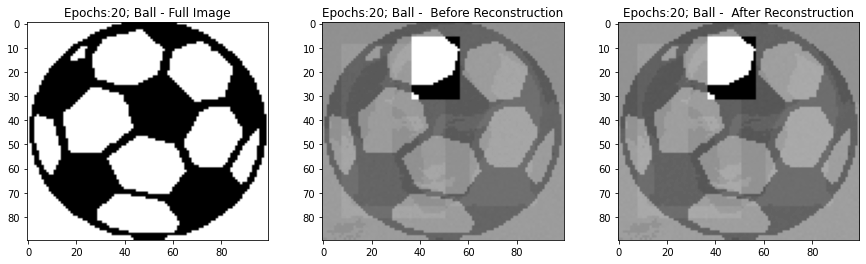

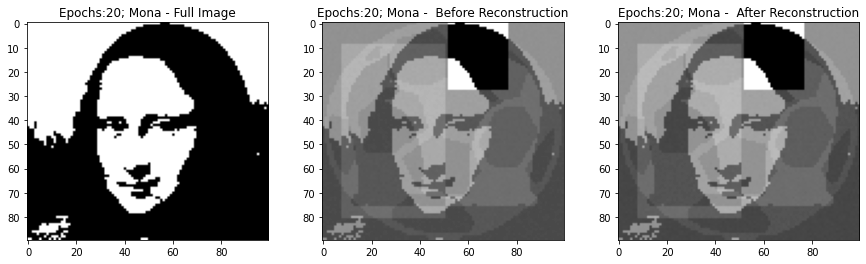

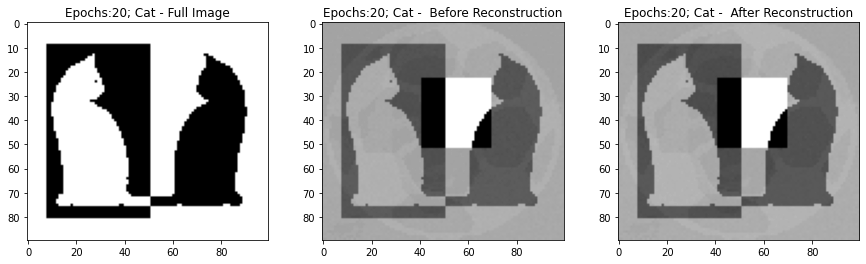

Training Continuous Hopfield Network:  31%|███▏      | 22/70 [00:05<00:16,  2.86it/s]

Training Continuous Hopfield Network:  43%|████▎     | 30/70 [00:06<00:05,  7.25it/s]

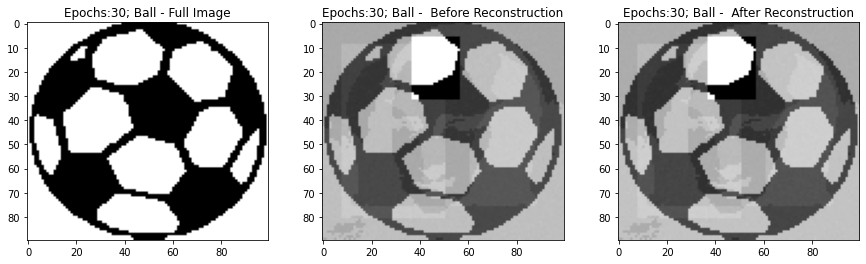

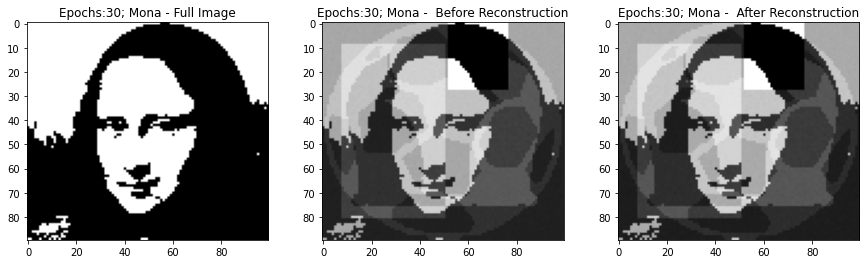

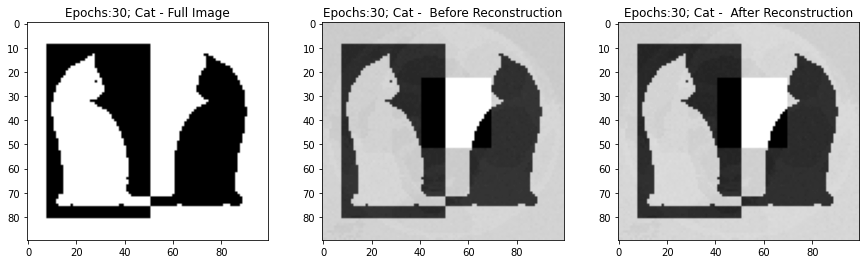

Training Continuous Hopfield Network:  46%|████▌     | 32/70 [00:08<00:14,  2.62it/s]

Training Continuous Hopfield Network:  57%|█████▋    | 40/70 [00:09<00:04,  6.94it/s]

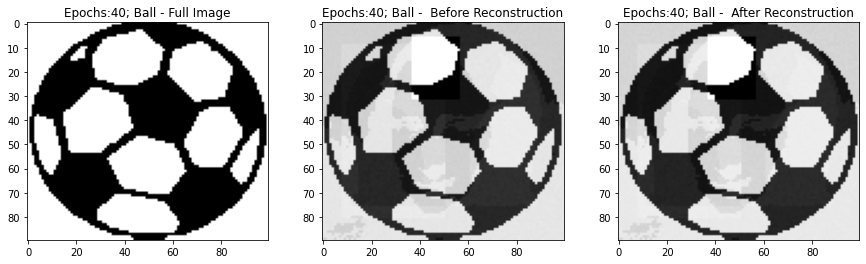

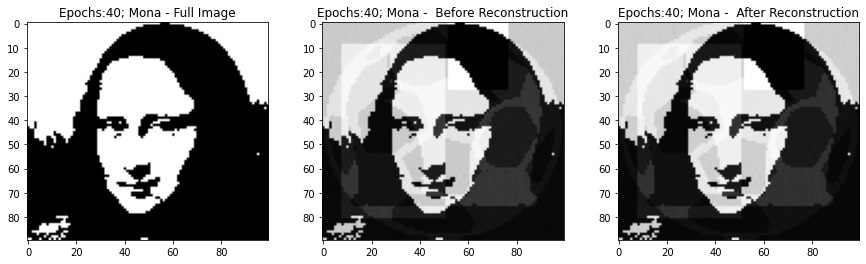

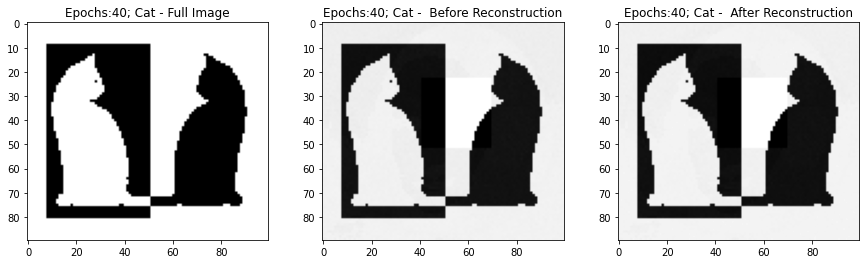

Training Continuous Hopfield Network:  60%|██████    | 42/70 [00:10<00:09,  2.80it/s]

Training Continuous Hopfield Network:  71%|███████▏  | 50/70 [00:11<00:02,  6.76it/s]

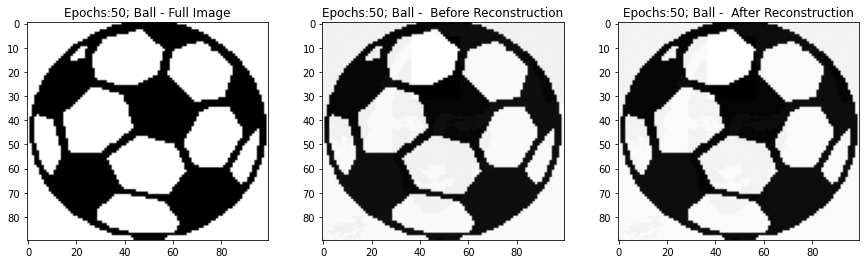

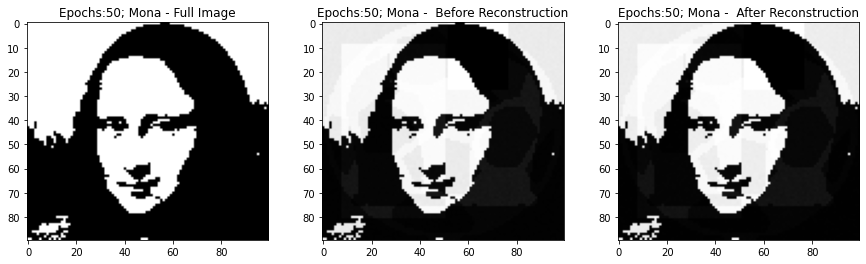

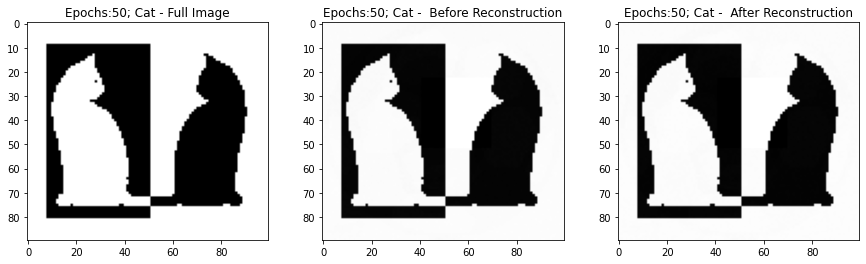

Training Continuous Hopfield Network:  74%|███████▍  | 52/70 [00:13<00:06,  2.59it/s]

Training Continuous Hopfield Network:  86%|████████▌ | 60/70 [00:14<00:01,  6.72it/s]

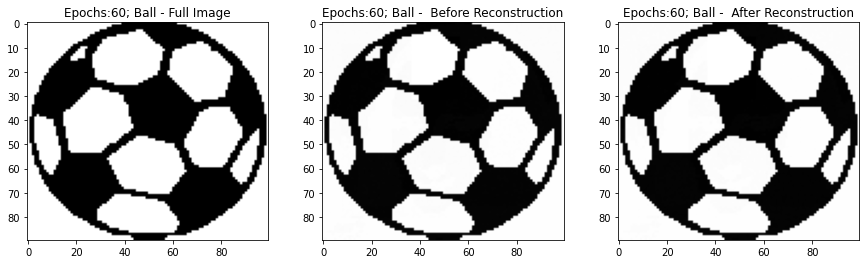

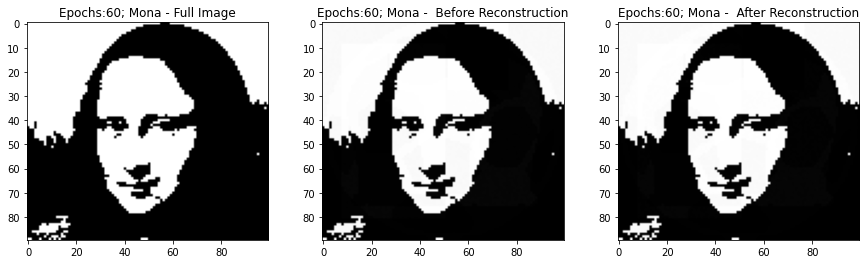

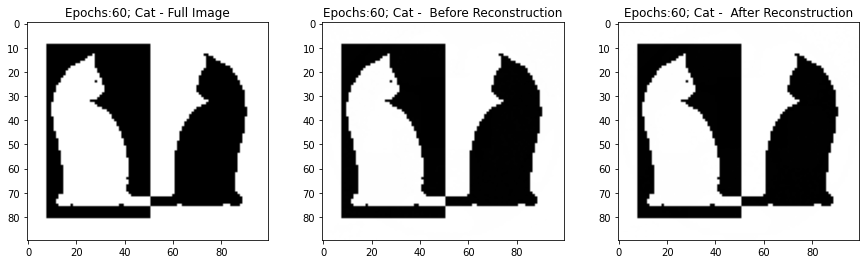

Training Continuous Hopfield Network:  89%|████████▊ | 62/70 [00:15<00:02,  2.80it/s]

Training Continuous Hopfield Network: 100%|██████████| 70/70 [00:16<00:00,  4.21it/s]


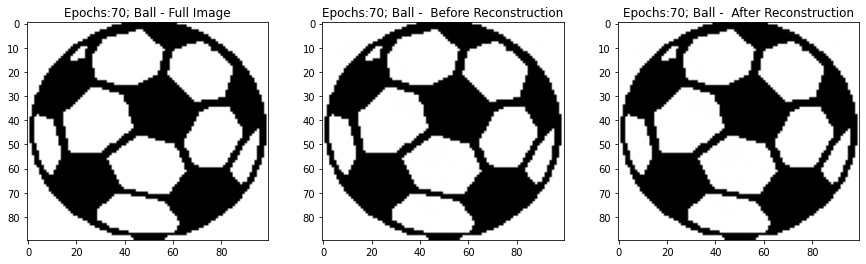

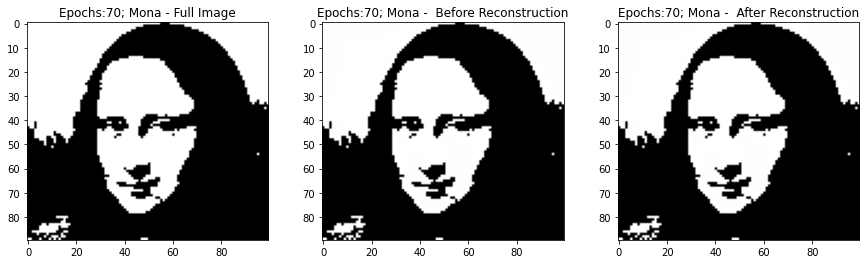

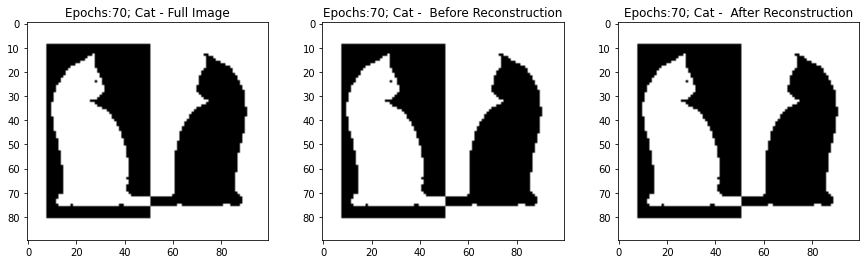

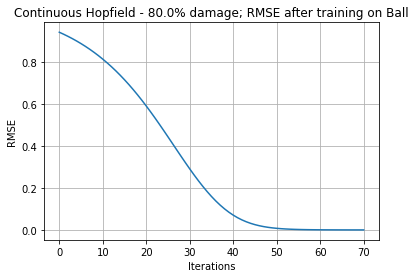

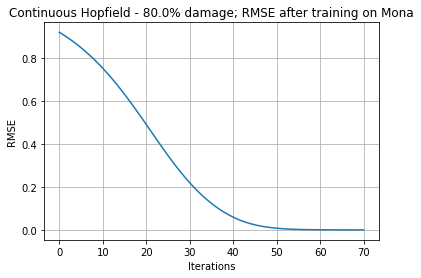

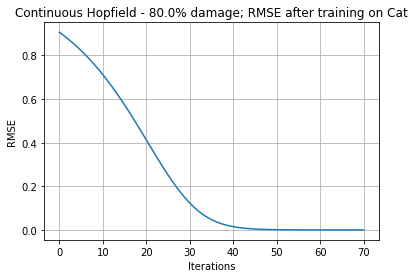

In [15]:
print("="*70)
print("80% Weight Damage")
p = 0.80
max_epochs = 70
rmse, V_final, V_hist_80 = continuous_hopfield(S, damage_weights(W, p), V_new, max_epochs, LAMBDA=LAMBDA, dt=dt, dummy=1, every=10)

rmse = np.array(rmse)
rmse_plotter(rmse, images, title=f"Continuous Hopfield - {p*100}% damage; RMSE after training on ")